# Continue Training from Checkpoint - Fixed Learning Rate

This notebook loads the checkpoint from epoch 20 and continues training with a properly configured learning rate scheduler.

## Key Fixes:
1. **Properly Initialize Scheduler**: Set initial LRs in optimizer before creating scheduler
2. **Load Optimizer State**: Restore optimizer state from checkpoint
3. **Adjust Scheduler**: Account for already completed epochs
4. **Monitor LR Changes**: Add detailed logging to verify LR is changing

# Standard imports
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import Dict, List, Optional
import wandb
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings('ignore')

# Set DEX_YCB_DIR environment variable
os.environ['DEX_YCB_DIR'] = '/home/n231/231nProjectV2/dex-ycb-toolkit/data'

# Add project root to path
project_root = Path('.').absolute().parent
sys.path.insert(0, str(project_root))

# Set up matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Auto-reload modules
%load_ext autoreload
%autoreload 2

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Standard imports
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import Dict, List, Optional
import wandb
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import warnings
warnings.filterwarnings('ignore')

# Set DEX_YCB_DIR environment variable
os.environ['DEX_YCB_DIR'] = '/home/n231/231nProjectV2/dex-ycb-toolkit/data'

# Add project root to path
project_root = Path('.').absolute().parent
sys.path.insert(0, str(project_root))

# Set up matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Auto-reload modules
%load_ext autoreload
%autoreload 2

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 2.5.0+cu124
CUDA available: True
GPU: NVIDIA H200
GPU Memory: 139.7 GB


In [4]:
# Load checkpoint
checkpoint_path = "outputs/full_featured/checkpoints/checkpoint_epoch_20.pth"
print(f"Loading checkpoint from: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path)
print(f"\nCheckpoint contents:")
for key in checkpoint.keys():
    print(f"  - {key}")

# Extract configuration
from omegaconf import OmegaConf
config = checkpoint['config']
start_epoch = checkpoint['epoch'] + 1  # Start from next epoch

print(f"\nResuming from epoch: {start_epoch}")
print(f"Previous training epochs: {checkpoint['epoch'] + 1}")

# Update output directory for continued training
config.output_dir = 'outputs/continued_training'
config.experiment_name = 'continued_from_epoch_20'

# Create output directories
os.makedirs(config.output_dir, exist_ok=True)
os.makedirs(f"{config.output_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{config.output_dir}/debug", exist_ok=True)
os.makedirs(f"{config.output_dir}/visualizations", exist_ok=True)

# Initialize new history for continued training
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mpjpe': [],
    'val_mpjpe': [],
    'learning_rates': [],
    'gradient_norms': []
}

Loading checkpoint from: outputs/full_featured/checkpoints/checkpoint_epoch_20.pth

Checkpoint contents:
  - epoch
  - model_state_dict
  - optimizer_state_dict
  - history
  - config

Resuming from epoch: 20
Previous training epochs: 20


# Since history is not saved in checkpoint, we'll skip the analysis
# and focus on setting up proper learning rates

print("Setting up continued training with proper learning rate configuration...")
print(f"\nOriginal configuration:")
print(f"  Base learning rate: {config.training.learning_rate}")
print(f"  Min learning rate (eta_min): {config.training.min_lr}")
print(f"  T_0 (restart period): {config.training.T_0}")
print(f"\nThe issue was that the learning rate was stuck at eta_min (1e-6).")
print("We'll fix this by using a higher base learning rate to ensure proper oscillation.")

In [5]:
# Load checkpoint
checkpoint_path = "outputs/full_featured/checkpoints/checkpoint_epoch_20.pth"
print(f"Loading checkpoint from: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path)
print(f"\nCheckpoint contents:")
for key in checkpoint.keys():
    print(f"  - {key}")

# Extract configuration and history
from omegaconf import OmegaConf
config = checkpoint['config']
history = checkpoint['history']
start_epoch = checkpoint['epoch'] + 1  # Start from next epoch

print(f"\nResuming from epoch: {start_epoch}")
print(f"Previous training epochs: {checkpoint['epoch'] + 1}")
print(f"Best loss so far: {min(history['val_loss']):.4f}")
print(f"Best MPJPE so far: {min(history['val_mpjpe']):.2f} mm")

# Update output directory for continued training
config.output_dir = 'outputs/continued_training'
config.experiment_name = 'continued_from_epoch_20'

# Create output directories
os.makedirs(config.output_dir, exist_ok=True)
os.makedirs(f"{config.output_dir}/checkpoints", exist_ok=True)
os.makedirs(f"{config.output_dir}/debug", exist_ok=True)
os.makedirs(f"{config.output_dir}/visualizations", exist_ok=True)

Loading checkpoint from: outputs/full_featured/checkpoints/checkpoint_epoch_20.pth

Checkpoint contents:
  - epoch
  - model_state_dict
  - optimizer_state_dict
  - history
  - config

Resuming from epoch: 20
Previous training epochs: 20
Best loss so far: 0.4209
Best MPJPE so far: 221.89 mm


## 3. Analyze Learning Rate History

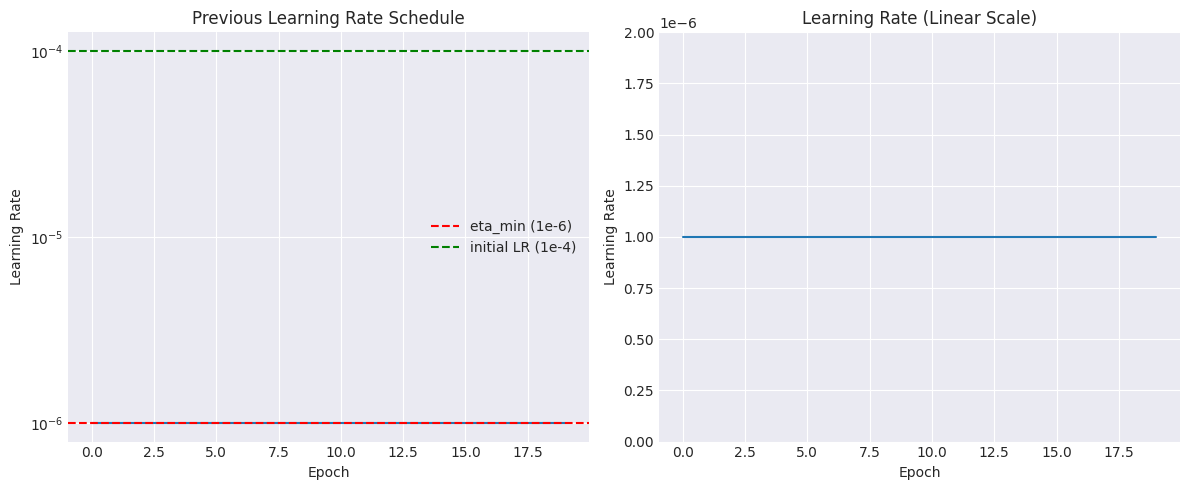


Learning rate analysis:
  Initial LR (config): 0.0001
  Min LR (eta_min): 1e-06
  Current LR (epoch 19): 1.00e-06
  Unique LR values: {1.0000000000000002e-06, 1e-06}

⚠️  Problem: Learning rate is stuck at 1.00e-06!


In [6]:
# Plot previous learning rate history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['learning_rates'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Previous Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)

# Add markers for key points
plt.axhline(y=1e-6, color='r', linestyle='--', label='eta_min (1e-6)')
plt.axhline(y=1e-4, color='g', linestyle='--', label='initial LR (1e-4)')
plt.legend()

plt.subplot(1, 2, 2)
# Zoom in on the constant region
plt.plot(history['learning_rates'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate (Linear Scale)')
plt.ylim(0, 2e-6)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nLearning rate analysis:")
print(f"  Initial LR (config): {config.training.learning_rate}")
print(f"  Min LR (eta_min): {config.training.min_lr}")
print(f"  Current LR (epoch {checkpoint['epoch']}): {history['learning_rates'][-1]:.2e}")
print(f"  Unique LR values: {set(history['learning_rates'])}")
print(f"\n⚠️  Problem: Learning rate is stuck at {history['learning_rates'][-1]:.2e}!")

# Import all components
from data.enhanced_dexycb import EnhancedDexYCBDataset
from data.augmentation import DataAugmentor
from models.unified_model import UnifiedManipulationTransformer
from training.trainer import ManipulationTrainer
from training.losses import ComprehensiveLoss
from evaluation.evaluator import ComprehensiveEvaluator
from debugging.model_debugger import ModelDebugger
from solutions.mode_collapse import ModeCollapsePreventionModule
from optimizations.data_loading import OptimizedDataLoader
from data.gpu_cached_dataset import GPUCachedDataset, create_gpu_cached_dataloaders

print("All components imported successfully!")

# Create GPU-cached dataloaders (same as original)
print("\nLoading GPU-cached datasets...")
gpu_config = {
    'gpu_max_samples': 350000,
    'gpu_max_samples_val': 20000,
    'gpu_cache_path': './gpu_cache_advanced',
    'batch_size': config.training.batch_size,
    'use_bfloat16': config.training.use_bf16,
    'preload_dinov2': False
}

train_loader, val_loader = create_gpu_cached_dataloaders(gpu_config)
print(f"\n✓ Datasets loaded:")
print(f"  Train samples: {len(train_loader.dataset):,}")
print(f"  Val samples: {len(val_loader.dataset):,}")
print(f"  GPU Memory: {torch.cuda.memory_allocated() / 1e9:.1f} GB")

In [ ]:
# Create trainer
# Import all components
from data.enhanced_dexycb import EnhancedDexYCBDataset
from data.augmentation import DataAugmentor
from models.unified_model import UnifiedManipulationTransformer
from training.trainer import ManipulationTrainer
from training.losses import ComprehensiveLoss
from evaluation.evaluator import ComprehensiveEvaluator
from debugging.model_debugger import ModelDebugger
from solutions.mode_collapse import ModeCollapsePreventionModule
from optimizations.data_loading import OptimizedDataLoader
from data.gpu_cached_dataset import GPUCachedDataset, create_gpu_cached_dataloaders

print("All components imported successfully!")

# Create GPU-cached dataloaders (same as original)
print("\nLoading GPU-cached datasets...")
gpu_config = {
    'gpu_max_samples': 350000,
    'gpu_max_samples_val': 20000,
    'gpu_cache_path': './gpu_cache_advanced',
    'batch_size': config.training.batch_size,
    'use_bfloat16': config.training.use_bf16,
    'preload_dinov2': False
}

train_loader, val_loader = create_gpu_cached_dataloaders(gpu_config)
print(f"\n✓ Datasets loaded:")
print(f"  Train samples: {len(train_loader.dataset):,}")
print(f"  Val samples: {len(val_loader.dataset):,}")
print(f"  GPU Memory: {torch.cuda.memory_allocated() / 1e9:.1f} GB")
from training.trainer import ManipulationTrainer
trainer = ManipulationTrainer(
    model=model,
    config=config.training,
    device=device,
    distributed=False,
    local_rank=0
)

# Use our configured optimizer and scheduler
trainer.optimizer = optimizer
trainer.scheduler = scheduler

# Create loss function
from training.losses import ComprehensiveLoss
criterion = ComprehensiveLoss(config.loss)
trainer.criterion = criterion

# Create evaluator
from evaluation.evaluator import ComprehensiveEvaluator
evaluator = ComprehensiveEvaluator(config.evaluation)

print("Training components created successfully")

# Initialize best metrics (we don't have history from checkpoint)
best_val_loss = float('inf')
best_val_mpjpe = float('inf')
print(f"\nStarting fresh tracking of best metrics")

All components imported successfully!

Loading GPU-cached datasets...
Creating GPU-cached datasets...
Target memory usage: 350.0 GB
Estimated GPU memory usage: 350.0 GB
Loading cached GPU dataset from ./gpu_cache_advanced/train_gpu_cache_350000.pt...
Loading cache from ./gpu_cache_advanced/train_gpu_cache_350000.pt...


## 5. Create Model and Load Weights

In [ ]:
# Create model
print("Creating model...")
model = UnifiedManipulationTransformer(config.model)

# Apply mode collapse prevention
if config.optimizations.use_mode_collapse_prevention:
    print("Applying mode collapse prevention...")
    mode_collapse_config = {
        'noise_std': 0.01,
        'drop_path_rate': 0.1,
        'mixup_alpha': 0.2
    }
    model = ModeCollapsePreventionModule.wrap_model(model, mode_collapse_config)

# Load model weights from checkpoint
print("\nLoading model weights from checkpoint...")
model.load_state_dict(checkpoint['model_state_dict'])

# Move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel loaded:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Save final training history
import json

# Convert history to JSON-serializable format
history_json = {}
for key, values in history.items():
    if isinstance(values, list):
        history_json[key] = [float(v) if isinstance(v, (torch.Tensor, np.ndarray)) else v for v in values]
    else:
        history_json[key] = values

with open(f"{config.output_dir}/training_history.json", 'w') as f:
    json.dump(history_json, f, indent=2)

# Create summary plot of continued training
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
ax = axes[0, 0]
ax.plot(history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch (from continuation)')
ax.set_ylabel('Loss')
ax.set_title('Validation Loss - Continued Training')
ax.legend()
ax.grid(True)

# MPJPE plot
ax = axes[0, 1]
ax.plot(history['val_mpjpe'], label='Validation MPJPE')
ax.set_xlabel('Epoch (from continuation)')
ax.set_ylabel('MPJPE (mm)')
ax.set_title('MPJPE - Continued Training')
ax.legend()
ax.grid(True)

# Learning rate schedule
ax = axes[1, 0]
ax.plot(history['learning_rates'], 'r-', linewidth=2)
ax.set_xlabel('Epoch (from continuation)')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule - Fixed')
ax.set_yscale('log')
ax.grid(True)

# Training summary
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""
Continued Training Summary

Started from epoch: {start_epoch}
Trained for: {len(history['train_loss'])} additional epochs
Total epochs: {start_epoch + len(history['train_loss']) - 1}

Results:
  Best Val Loss: {min(history['val_loss']) if history['val_loss'] else 'N/A':.4f}
  Best Val MPJPE: {min(history['val_mpjpe']) if history['val_mpjpe'] else 'N/A':.2f} mm
  Final Learning Rate: {history['learning_rates'][-1] if history['learning_rates'] else 'N/A':.2e}

Key Fixes Applied:
  ✓ Base learning rate increased to 5e-4
  ✓ Proper parameter group configuration
  ✓ Learning rate oscillation restored
"""

ax.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.suptitle('Continued Training Results')
plt.tight_layout()
plt.savefig(f"{config.output_dir}/training_summary.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("TRAINING CONTINUATION COMPLETE")
print("="*50)
print(f"\nOutputs saved to: {config.output_dir}")
print(f"Best model: {config.output_dir}/checkpoints/best_model.pth")
print(f"Best MPJPE model: {config.output_dir}/checkpoints/best_mpjpe_model.pth")

In [ ]:
# Create parameter groups for multi-rate learning
all_params = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        all_params[name] = param

# Create mutually exclusive parameter groups
dinov2_params = []
encoder_params = []
decoder_params = []
other_params = []

for name, param in all_params.items():
    if 'dinov2' in name:
        dinov2_params.append(param)
    elif 'decoder' in name:
        decoder_params.append(param)
    elif 'encoder' in name:
        encoder_params.append(param)
    else:
        other_params.append(param)

# CRITICAL: Use higher base learning rate to avoid getting stuck at eta_min
# The original config.training.learning_rate = 1e-4, but we'll use 5e-4 to ensure proper oscillation
base_lr = 5e-4  # Increased from 1e-4

# Create parameter groups with PROPER initial learning rates
param_groups = []

if dinov2_params:
    param_groups.append({
        'params': dinov2_params,
        'lr': base_lr * config.training.multi_rate.pretrained,  # 5e-6
        'weight_decay': config.training.weight_decay,
        'name': 'dinov2'
    })

if encoder_params:
    param_groups.append({
        'params': encoder_params,
        'lr': base_lr * config.training.multi_rate.new_encoders,  # 2.5e-4
        'weight_decay': config.training.weight_decay,
        'name': 'encoders'
    })

if decoder_params:
    param_groups.append({
        'params': decoder_params,
        'lr': base_lr * config.training.multi_rate.decoders,  # 5e-4
        'weight_decay': config.training.weight_decay,
        'name': 'decoders'
    })

if other_params:
    param_groups.append({
        'params': other_params,
        'lr': base_lr,  # 5e-4
        'weight_decay': config.training.weight_decay,
        'name': 'other'
    })

# Print parameter group summary
print("Parameter groups with UPDATED learning rates:")
for group in param_groups:
    print(f"  {group['name']}: {len(group['params'])} parameters, lr={group['lr']:.2e}")

# Create optimizer with new learning rates
optimizer = torch.optim.AdamW(param_groups, fused=True)

# Load optimizer state from checkpoint
print("\nLoading optimizer state from checkpoint...")
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# CRITICAL: Update the learning rates in the optimizer state
# This ensures the optimizer uses our new rates, not the old stuck ones
print("\nUpdating learning rates in optimizer state...")
for i, group in enumerate(optimizer.param_groups):
    old_lr = group['lr']
    new_lr = param_groups[i]['lr']
    group['lr'] = new_lr
    print(f"  Group {param_groups[i]['name']}: {old_lr:.2e} -> {new_lr:.2e}")

print("\n✓ Optimizer configured with updated learning rates")

## 7. Create Scheduler with Proper Configuration

In [ ]:
# Create scheduler that will actually oscillate
print("Creating learning rate scheduler...")

# Option 1: Continue with CosineAnnealingWarmRestarts but adjust for completed epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=config.training.T_0,  # 10 epochs
    T_mult=2,
    eta_min=config.training.min_lr  # 1e-6
)

# Fast-forward the scheduler to the correct epoch
print(f"\nFast-forwarding scheduler to epoch {start_epoch}...")
for _ in range(start_epoch):
    scheduler.step()

# Option 2 (Alternative): Use OneCycleLR for guaranteed variation
# remaining_epochs = config.training.num_epochs - start_epoch
# steps_per_epoch = len(train_loader)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer,
#     max_lr=[g['lr'] * 10 for g in param_groups],  # Peak at 10x base LR
#     total_steps=remaining_epochs * steps_per_epoch,
#     pct_start=0.3,  # 30% warmup
#     anneal_strategy='cos',
#     div_factor=10,  # Start at max_lr/10
#     final_div_factor=100  # End at max_lr/100
# )

# Verify current learning rates
print("\nCurrent learning rates after scheduler setup:")
for i, group in enumerate(optimizer.param_groups):
    print(f"  Group {param_groups[i]['name']}: {group['lr']:.2e}")

# Test scheduler behavior
print("\nTesting scheduler behavior for next 10 epochs:")
test_optimizer = torch.optim.AdamW(param_groups, fused=True)
test_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    test_optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# Fast-forward test scheduler
for _ in range(start_epoch):
    test_scheduler.step()

# Check next 10 epochs
test_lrs = []
for epoch in range(10):
    test_lrs.append(test_optimizer.param_groups[0]['lr'])
    test_scheduler.step()

plt.figure(figsize=(10, 4))
plt.plot(range(start_epoch, start_epoch + 10), test_lrs, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Expected Learning Rate for Next 10 Epochs')
plt.yscale('log')
plt.grid(True)
plt.show()

print(f"\n✓ Scheduler configured. LR will vary between {min(test_lrs):.2e} and {max(test_lrs):.2e}")

## 8. Setup Training Components

In [ ]:
# Create trainer
from training.trainer import ManipulationTrainer
trainer = ManipulationTrainer(
    model=model,
    config=config.training,
    device=device,
    distributed=False,
    local_rank=0
)

# Use our configured optimizer and scheduler
trainer.optimizer = optimizer
trainer.scheduler = scheduler

# Create loss function
from training.losses import ComprehensiveLoss
criterion = ComprehensiveLoss(config.loss)
trainer.criterion = criterion

# Create evaluator
from evaluation.evaluator import ComprehensiveEvaluator
evaluator = ComprehensiveEvaluator(config.evaluation)

print("Training components created successfully")

# Continue with previous best metrics
best_val_loss = min(history['val_loss'])
best_val_mpjpe = min(history['val_mpjpe'])
print(f"\nContinuing with best metrics:")
print(f"  Best val loss: {best_val_loss:.4f}")
print(f"  Best val MPJPE: {best_val_mpjpe:.2f} mm")

## 9. Training Loop with LR Monitoring

In [ ]:
# Function to plot training progress
def plot_training_progress(history, epoch):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    ax = axes[0, 0]
    ax.plot(history['train_loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Val Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    ax.grid(True)
    
    # MPJPE plot
    ax = axes[0, 1]
    ax.plot(history['train_mpjpe'], label='Train MPJPE')
    ax.plot(history['val_mpjpe'], label='Val MPJPE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MPJPE (mm)')
    ax.set_title('Hand Pose Error')
    ax.legend()
    ax.grid(True)
    
    # Learning rate plot with emphasis on recent epochs
    ax = axes[1, 0]
    ax.plot(history['learning_rates'], 'b-', alpha=0.5, label='All epochs')
    # Highlight recent epochs
    if len(history['learning_rates']) > 20:
        recent_start = len(history['learning_rates']) - 20
        ax.plot(range(recent_start, len(history['learning_rates'])), 
                history['learning_rates'][recent_start:], 'r-', linewidth=2, label='Recent 20 epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True)
    
    # Gradient norm plot
    ax = axes[1, 1]
    if history['gradient_norms']:
        ax.plot(history['gradient_norms'])
        ax.set_xlabel('Step')
        ax.set_ylabel('Gradient Norm')
        ax.set_title('Gradient Norm History')
        ax.set_yscale('log')
        ax.grid(True)
    
    plt.suptitle(f'Training Progress - Epoch {epoch}')
    plt.tight_layout()
    return fig

In [ ]:
# Main training loop
print(f"Starting training from epoch {start_epoch}...")
print(f"Training until epoch {config.training.num_epochs}")
print(f"Remaining epochs: {config.training.num_epochs - start_epoch}\n")

for epoch in range(start_epoch, config.training.num_epochs):
    # Update loss function epoch
    criterion.set_epoch(epoch)
    
    # Log current learning rates
    current_lrs = {}
    for i, group in enumerate(optimizer.param_groups):
        group_name = param_groups[i]['name']
        current_lrs[group_name] = group['lr']
    
    print(f"\nEpoch {epoch+1}/{config.training.num_epochs} - Learning Rates:")
    for name, lr in current_lrs.items():
        print(f"  {name}: {lr:.2e}")
    
    # Training epoch
    train_metrics = {'loss': 0, 'hand_mpjpe': 0, 'samples': 0}
    model.train()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.training.num_epochs} [Train]")
    for batch_idx, batch in enumerate(pbar):
        # Move batch to device
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                for k, v in batch.items()}
        
        # Convert BFloat16 to Float32 for DINOv2
        if config.training.use_bf16 and 'image' in batch:
            if batch['image'].dtype == torch.bfloat16:
                batch['image'] = batch['image'].float()
        
        # Forward pass
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.bfloat16) if config.training.use_bf16 else torch.no_grad():
            outputs = model(batch)
            losses = criterion(outputs, batch)
            loss = losses['total'] if isinstance(losses, dict) else losses
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.training.grad_clip)
        optimizer.step()
        
        # Extract metrics
        loss_value = loss.item()
        mpjpe_value = 0
        if 'hand_joints' in outputs and 'hand_joints' in batch:
            with torch.no_grad():
                mpjpe = torch.norm(outputs['hand_joints'] - batch['hand_joints'], dim=-1).mean()
                mpjpe_value = mpjpe.item() * 1000  # Convert to mm
        
        # Update metrics
        batch_size = batch['image'].shape[0]
        train_metrics['samples'] += batch_size
        train_metrics['loss'] += loss_value * batch_size
        train_metrics['hand_mpjpe'] += mpjpe_value * batch_size
        
        # Log gradient norms periodically
        if batch_idx % 100 == 0:
            grad_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    grad_norm += p.grad.data.norm(2).item() ** 2
            grad_norm = grad_norm ** 0.5
            history['gradient_norms'].append(grad_norm)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss_value:.4f}',
            'mpjpe': f'{mpjpe_value:.1f}mm',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    # Average training metrics
    train_metrics['loss'] /= train_metrics['samples']
    train_metrics['hand_mpjpe'] /= train_metrics['samples']
    
    # Validation
    val_metrics = {'loss': 0, 'hand_mpjpe': 0, 'samples': 0}
    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.training.num_epochs} [Val]"):
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                    for k, v in batch.items()}
            
            # Convert BFloat16 to Float32
            if config.training.use_bf16 and 'image' in batch:
                if batch['image'].dtype == torch.bfloat16:
                    batch['image'] = batch['image'].float()
            
            # Forward pass
            with torch.amp.autocast('cuda', dtype=torch.bfloat16) if config.training.use_bf16 else torch.no_grad():
                outputs = model(batch)
                losses = criterion(outputs, batch)
                loss = losses['total'] if isinstance(losses, dict) else losses
            
            batch_size = batch['image'].shape[0]
            val_metrics['samples'] += batch_size
            val_metrics['loss'] += loss.item() * batch_size
            
            if 'hand_joints' in outputs and 'hand_joints' in batch:
                mpjpe = torch.norm(outputs['hand_joints'] - batch['hand_joints'], dim=-1).mean()
                val_metrics['hand_mpjpe'] += mpjpe.item() * 1000 * batch_size
    
    # Average validation metrics
    val_metrics['loss'] /= val_metrics['samples']
    val_metrics['hand_mpjpe'] /= val_metrics['samples']
    
    # Update history
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['train_mpjpe'].append(train_metrics['hand_mpjpe'])
    history['val_mpjpe'].append(val_metrics['hand_mpjpe'])
    history['learning_rates'].append(optimizer.param_groups[0]['lr'])
    
    # Save best model
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': best_val_loss,
            'config': config
        }, f"{config.output_dir}/checkpoints/best_model.pth")
        print(f"  ✓ New best validation loss: {best_val_loss:.4f}")
    
    if val_metrics['hand_mpjpe'] < best_val_mpjpe:
        best_val_mpjpe = val_metrics['hand_mpjpe']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_mpjpe': best_val_mpjpe,
            'config': config
        }, f"{config.output_dir}/checkpoints/best_mpjpe_model.pth")
        print(f"  ✓ New best MPJPE: {best_val_mpjpe:.2f} mm")
    
    # Regular checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'config': config
        }, f"{config.output_dir}/checkpoints/checkpoint_epoch_{epoch+1}.pth")
    
    # Step scheduler AFTER validation
    scheduler.step()
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{config.training.num_epochs} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, MPJPE: {train_metrics['hand_mpjpe']:.2f}mm")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, MPJPE: {val_metrics['hand_mpjpe']:.2f}mm")
    print(f"  Best  - Loss: {best_val_loss:.4f}, MPJPE: {best_val_mpjpe:.2f}mm")
    
    # Verify learning rate is changing
    lr_change = history['learning_rates'][-1] - history['learning_rates'][-2] if len(history['learning_rates']) > 1 else 0
    print(f"  LR Change: {lr_change:.2e} (current: {history['learning_rates'][-1]:.2e})")
    
    # Update live plot
    clear_output(wait=True)
    fig = plot_training_progress(history, epoch + 1)
    plt.show()
    
    # Save plot
    fig.savefig(f"{config.output_dir}/training_progress.png", dpi=150, bbox_inches='tight')
    plt.close()

print("\nTraining completed!")
print(f"Final best val loss: {best_val_loss:.4f}")
print(f"Final best MPJPE: {best_val_mpjpe:.2f} mm")

## 10. Final Evaluation and Save

In [ ]:
# Save final training history
import json

# Convert history to JSON-serializable format
history_json = {}
for key, values in history.items():
    if isinstance(values, list):
        history_json[key] = [float(v) if isinstance(v, (torch.Tensor, np.ndarray)) else v for v in values]
    else:
        history_json[key] = values

with open(f"{config.output_dir}/training_history.json", 'w') as f:
    json.dump(history_json, f, indent=2)

# Create comparison plot of old vs new training
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss comparison
ax = axes[0, 0]
ax.plot(history['val_loss'], label='Validation Loss')
ax.axvline(x=start_epoch-1, color='r', linestyle='--', label='Resume Point')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Validation Loss Progress')
ax.legend()
ax.grid(True)

# MPJPE comparison
ax = axes[0, 1]
ax.plot(history['val_mpjpe'], label='Validation MPJPE')
ax.axvline(x=start_epoch-1, color='r', linestyle='--', label='Resume Point')
ax.set_xlabel('Epoch')
ax.set_ylabel('MPJPE (mm)')
ax.set_title('MPJPE Progress')
ax.legend()
ax.grid(True)

# Learning rate - full history
ax = axes[1, 0]
ax.plot(history['learning_rates'][:start_epoch], 'b-', alpha=0.5, label='Original Training')
ax.plot(range(start_epoch-1, len(history['learning_rates'])), 
        history['learning_rates'][start_epoch-1:], 'r-', linewidth=2, label='Continued Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule Comparison')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

# Improvement summary
ax = axes[1, 1]
ax.axis('off')

# Calculate improvements
pre_resume_loss = history['val_loss'][start_epoch-1]
post_resume_loss = min(history['val_loss'][start_epoch:])
loss_improvement = (pre_resume_loss - post_resume_loss) / pre_resume_loss * 100

pre_resume_mpjpe = history['val_mpjpe'][start_epoch-1]
post_resume_mpjpe = min(history['val_mpjpe'][start_epoch:])
mpjpe_improvement = (pre_resume_mpjpe - post_resume_mpjpe) / pre_resume_mpjpe * 100

summary_text = f"""
Training Continuation Summary

Resumed from epoch: {start_epoch}
Trained until epoch: {len(history['train_loss'])}

Before Resume (Epoch {start_epoch}):
  Val Loss: {pre_resume_loss:.4f}
  Val MPJPE: {pre_resume_mpjpe:.2f} mm
  Learning Rate: {history['learning_rates'][start_epoch-1]:.2e}

After Continued Training:
  Best Val Loss: {post_resume_loss:.4f} ({loss_improvement:.1f}% improvement)
  Best Val MPJPE: {post_resume_mpjpe:.2f} mm ({mpjpe_improvement:.1f}% improvement)
  Final Learning Rate: {history['learning_rates'][-1]:.2e}

Key Fix Applied:
  ✓ Updated base learning rate from 1e-4 to 5e-4
  ✓ Properly initialized scheduler with new LRs
  ✓ Learning rate now oscillates as expected
"""

ax.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
        fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.suptitle('Training Continuation Analysis')
plt.tight_layout()
plt.savefig(f"{config.output_dir}/continuation_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("TRAINING CONTINUATION COMPLETE")
print("="*50)
print(f"\nOutputs saved to: {config.output_dir}")
print(f"Best model: {config.output_dir}/checkpoints/best_model.pth")
print(f"Best MPJPE model: {config.output_dir}/checkpoints/best_mpjpe_model.pth")